In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_array=cv2.imread("dataset/face_mask/00000_Mask.jpg")

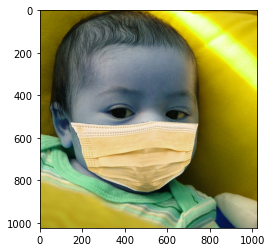

In [3]:
plt.imshow(img_array)

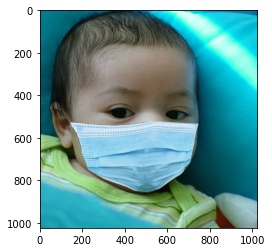

In [4]:
plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))

In [5]:
img_array.shape


(1024, 1024, 3)

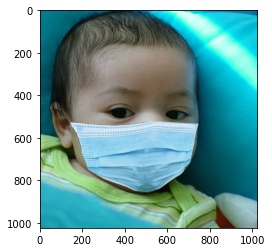

In [6]:
Datadirectory="dataset/"
Classes=["face_mask","no_mask"]
for category in Classes:
    path=os.path.join(Datadirectory,category)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        #backtorgb=cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
        plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
        plt.show()
        break
    break

<function matplotlib.pyplot.show(close=None, block=None)>

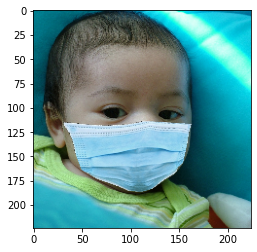

In [7]:
img_size=224 ## ImageNet=224x224
new_array=cv2.resize(img_array,(img_size,img_size))
plt.imshow(cv2.cvtColor(new_array,cv2.COLOR_BGR2RGB))
plt.show

#Reading the image and converting all to array

In [8]:
training_data=[]

def create_training_data():
    for category in Classes:
        path=os.path.join(Datadirectory,category)
        class_num=Classes.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(img_size,img_size))
                training_data.append([new_array,class_num])
            except Exception as e:
                    pass
    

In [9]:
create_training_data()

In [10]:
print(len(training_data))

1950


#shuffling images so that model doesn't get overfitted.


In [11]:
import random
random.shuffle(training_data)

In [12]:
x=[]
y=[]

for features,label in training_data:
    x.append(features)
    y.append(label)
    
    
x=np.array(x).reshape(-1,img_size,img_size,3)

In [13]:
x.shape

(1950, 224, 224, 3)

In [14]:
#normalize the data
x=x/225.0;#we are normalizing it

In [15]:
y[1000]

1

In [16]:
y=np.array(y)

In [17]:
import pickle

pickle_out=open("x.pickle","wb")
pickle.dump(x,pickle_out)
pickle_out.close()

pickle_out=open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

In [18]:
pickle_in=open("x.pickle","rb")
x=pickle.load(pickle_in)

pickle_in=open("y.pickle","rb")
y=pickle.load(pickle_in)

#Deep learning model for training

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [20]:
model=tf.keras.applications.mobilenet.MobileNet()

In [21]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32

#Transfer learning-Tuning,weights will start from last check point.

In [22]:
base_input=model.layers[0].input

In [23]:
base_output=model.layers[-4].output

In [24]:
Flat_layer=layers.Flatten()(base_output)
final_output=layers.Dense(1)(Flat_layer)
final_ouput=layers.Activation('sigmoid')(final_output)

In [25]:
new_model=keras.Model(inputs=base_input,outputs=final_output)

In [26]:
new_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 112, 112, 32)      0     

Setting forbinary classification(Face mask/Without Mask)

In [27]:
new_model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [28]:
new_model.fit(x,y, epochs=1,validation_split=0.1)

55/55 [==============================] - 438s 7s/step - loss: 0.4634 - accuracy: 0.9652 - val_loss: 0.1582 - val_accuracy: 0.9897


In [29]:
new_model.save('my_model13.h5')

In [30]:
new_model=tf.keras.models.load_model('my_model13.h5')

Checking the network for predictions

In [31]:
frame=cv2.imread('00002_Mask.jpg')

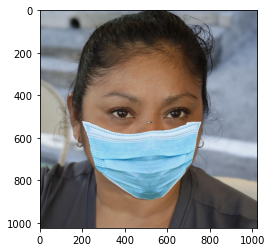

In [32]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [33]:
final_image=cv2.resize(frame,(224,224))
final_image=np.expand_dims(final_image,axis=0)##need forth dimension
final_image=final_image/255.0

In [34]:
predictions=new_model.predict(final_image)

In [35]:
predictions

array([[-16.051176]], dtype=float32)

Checking the network for unknown image.

In [36]:
frame=cv2.imread('sad_women.jpg')

In [37]:
frame.shape

(168, 299, 3)

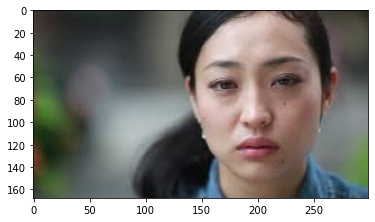

In [38]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [39]:
faceCascade=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

In [40]:
gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

In [41]:
gray.shape

(168, 299)

In [42]:
faces=faceCascade.detectMultiScale(gray,1.1,4)
for x,y,w,h in faces:
    roi_gray=gray[y:y+h,x:x+w]
    roi_color=frame[y:y+h,x:x+w]
    cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
    facess=faceCascade.detectMultiScale(roi_gray)
    if len(facess)==0:
        print('Face not detected')
    else:
        for(ex,ey,ew,eh) in facess:
            face_roi=roi_color[ey:ey+eh,ex:ex+ew]

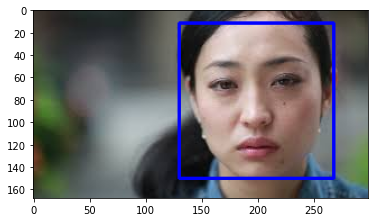

In [43]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

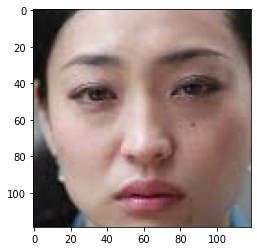

In [44]:
plt.imshow(cv2.cvtColor(face_roi,cv2.COLOR_BGR2RGB))

In [45]:
final_image=cv2.resize(face_roi,(224,224))
final_image=np.expand_dims(final_image,axis=0)##need forth dimension
final_image=final_image/255.0

In [46]:
Predictions=new_model.predict(final_image)

In [47]:
Predictions

array([[24.584078]], dtype=float32)

Realtime video demo.

Face Mask Detection

In [49]:
import cv2
path='haarcascade_frontalface_default.xml'
font_scale=1.5
font=cv2.FONT_HERSHEY_PLAIN


rectangle_bgr=(255,255,255)

img=np.zeros((500,500))

text="some text in a box!"

(text_width,text_height)=cv2.getTextSize(text,font,fontScale=font_scale,thickness=1)[0]


text_offset_x=10

text_offset_y=img.shape[0]-25


box_coords=((text_offset_x,text_offset_y),(text_offset_x+text_width+2,text_offset_y-text_height-2))
cv2.rectangle(img,box_coords[0],box_coords[1],rectangle_bgr,cv2.FILLED)
cv2.putText(img,text,(text_offset_x,text_offset_y),font,fontScale=font_scale,color=(0,0,0),thickness=1)

cap=cv2.VideoCapture(1)
# check if the webcam is opened correctly.
if not cap.isOpened():
    cap=cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("can not open webcam")
    
    
while True:
    ret,frame=cap.read()
    faceCascade=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    
    
    faces=faceCascade.detectMultiScale(gray,1.1,4)
    for x,y,w,h in faces:
        roi_gray=gray[y:y+h,x:x+w]
        roi_color=frame[y:y+h,x:x+w]
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        facess=faceCascade.detectMultiScale(roi_gray)
        if len(facess)==0:
            print('Face not detected')
        else:
            for(ex,ey,ew,eh) in facess:
                face_roi=roi_color[ey:ey+eh,ex:ex+ew]#croping the face
                
                
    final_image=cv2.resize(face_roi,(224,224))
    final_image=np.expand_dims(final_image,axis=0)##need forth dimension
    final_image=final_image/255.0
    font=cv2.FONT_HERSHEY_SIMPLEX
    Predictions=new_model.predict(final_image)
    
    
    font_scale=1.5
    font=cv2.FONT_HERSHEY_PLAIN
    
    
    if (Predictions>0):
        status="No Mask"
        
        
        x1,y1,w1,h1=0,0,175,75
        #Draw blacck background rectangle
        cv2.rectangle(frame,(x1,x1),(x1+w1, y1+h1),(0,0,0),-1)
        #Add text
        cv2.putText(frame,status,(x1+int(w1/10),y1+int(h1/2)),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255),2)
        cv2.putText(frame,status,(100,150),font,3,(0,0,255),2,cv2.LINE_4)
        
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255))
        
    else:
        status="Face Mask"
        
        
        x1,y1,w1,h1=0,0,175,75
        #Draw blacck background rectangle
        cv2.rectangle(frame,(x1,x1),(x1+w1, y1+h1),(0,0,0),-1)
        #Add text
        cv2.putText(frame,status,(x1+int(w1/10),y1+int(h1/2)),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),2)
        cv2.putText(frame,status,(100,150),font,3,(0,255,0),2,cv2.LINE_4)
        
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0))
        
        
        
        
    cv2.imshow('Face Mask Detection',frame)
    
    if cv2.waitKey(2)&0xff==ord('q'):
        break
        
        
cap.release()
cv2.destroyAllWindows()
        
        
        
        

    

Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not d

Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not d

KeyboardInterrupt: 